# Emotion Recognition from Twitter Posts

Building a system for automatic categorization of text into six emotions using text-based emotion recognition with LSTMs.

A dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. 
The dataset can be retrieved from either https://github.com/dair-ai/emotion_dataset or Kaggle https://www.kaggle.com/datasets/parulpandey/emotion-dataset/ .




In [1]:
#import libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import sys
sys.path.append("src")


## Importing and Splitting the Data


In [2]:
#load the datasets
train = pd.read_csv('data/training.csv')
val = pd.read_csv('data/validation.csv')
test = pd.read_csv('data/test.csv')

In [3]:
#inspecting shape of data
print("Train data :",train.shape)
print("Validation data :",val.shape)
print("Test data :",test.shape)

Train data : (16000, 2)
Validation data : (2000, 2)
Test data : (2000, 2)


In [4]:
#looking at the first 10 rows
train.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [5]:
#check for missing values
print(train.isnull().sum())
print(val.isnull().sum())
print(test.isnull().sum())

text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


We have two variables: 
- text: a string feature (the tweet)
- label: a classification label, with possible values including 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise'.

In [6]:
#interating over examples and storing the tweets and labels in lists
def get_tweet(dataframe):
    tweets = dataframe['text'].tolist()
    labels = dataframe['label'].tolist()
    return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

## Preparing the Labels

In [8]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


In [9]:
# Emotions in the order specified
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Create a dictionary that maps from emotion to index
class_to_index = {emotion: index for index, emotion in enumerate(emotions)}

# Create a dictionary that maps from index to emotion
index_to_class = {index: emotion for emotion, index in class_to_index.items()}

# Test
print(class_to_index)  
print(index_to_class) 

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [10]:
#adding a string label column
train['label_name'] = train['label'].map(index_to_class)
val['label_name'] = val['label'].map(index_to_class)
test['label_name'] = test['label'].map(index_to_class)

train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


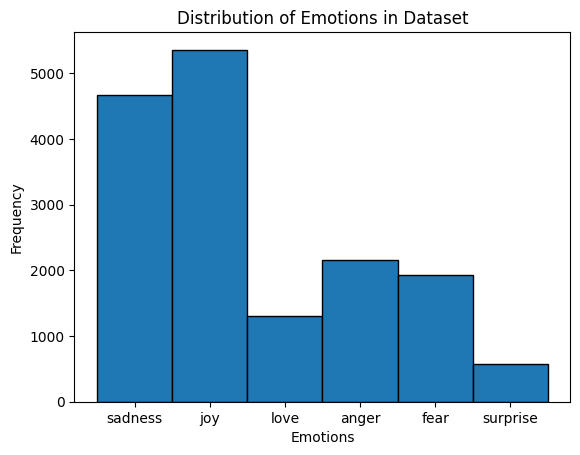

In [11]:
#plotting the distribution of labels
plt.hist(labels, bins=range(len(emotions) + 1), align='left', edgecolor='black')

# Set the x-ticks to be at the center of each bin
plt.xticks(ticks=range(len(emotions)), labels=emotions)

# Optionally, set labels for x and y axis
plt.xlabel('Emotions')
plt.ylabel('Frequency')

# Optionally, set a title
plt.title('Distribution of Emotions in Dataset')

# Display the histogram
plt.show()


In [12]:
# distribution in numbers
train.groupby(["label", "label_name"]).size()

label  label_name
0      sadness       4666
1      joy           5362
2      love          1304
3      anger         2159
4      fear          1937
5      surprise       572
dtype: int64

## Tokenizer

Using tensorflows built-in tokenizer in order to convert the text into numbers. Each word is going to get an own token.

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

#create a tokenizer object using the tokenizer class only using the 10000 most common words in our corpus; others replaced with UNK
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [14]:
#check functioning of tokenizer 
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Padding and Truncating of Sequences

Model needs fixed input shape, so we ensure all sequences have the same length.

<module 'matplotlib.pyplot' from '/Users/katjad/anaconda3/envs/PythonIntro/lib/python3.11/site-packages/matplotlib/pyplot.py'>

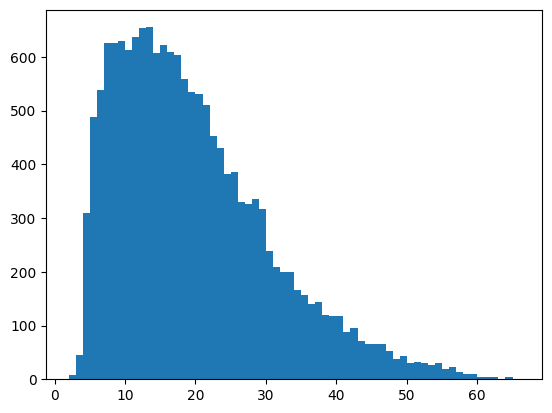

In [15]:
#get and plot length of tweets
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 50

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)  #converts tweets into sequences of integers
    padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen) #ensures all sequences have the same length by padding or truncating
    return padded_sequences

In [17]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [18]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Creating the Model before Optuna

Architecture:
- Embedding Layer: turns positive integers (indexes) into dense vectors of fixed size, here 16-dimensional.
- Bidirectional LSTM Layers: A Bidirectional wrapper for LSTM layers. The first bidirectional LSTM layer returns the last output in the output sequence for each input sequence (necessary for stacking another LSTM layer on top). The second LSTM layer is also bidirectional and is followed by
- the Dense Output Layer: with softmax activation function.

Dropout was added to reduce overfitting:
- Input dropout in LSTM layer: randomly sets a fraction of the input units to 0 at each update during training time, which helps prevent overfitting on the input side of the LSTM units
- (not used/no improvement but also possible:recurrent_dropout=0.5 inside LSTM: This means xx% of the recurrent connections will be randomly excluded from each update during training.)
- dropout layer: affects the entire output of the preceding layer

In [25]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),   #embedding layer, each word represented as a 16-dimensional vector
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True,
                                                       dropout=0.5)),  #bidirectional LSTM layer, the context in LSTM can go in both directions (left-right), returns output of all of the cells and not just last cell
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, dropout=0.5)),  #bidirectional LSTM layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')  #dense layer with softmax activation 
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175

In [51]:
#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model", monitor='val_accuracy', verbose=0,
    save_best_only=True, mode='max', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks = [
    checkpoint, 
    #early, 
    reduce_lr]

## Training the Model before Optuna

In [28]:
#preparing the validation set
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)


In [29]:
#train the model

h = model.fit(
    padded_train_seq, np.array(labels),
    validation_data=(val_seq, np.array(val_labels)),
    epochs=50,
    callbacks=callbacks,
)


Epoch 1/50
499/500 [============================>.] - ETA: 0s - loss: 1.5634 - accuracy: 0.3384INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 13s 22ms/step - loss: 1.5632 - accuracy: 0.3384 - val_loss: 1.3525 - val_accuracy: 0.4145 - lr: 0.0010
Epoch 2/50
496/500 [============================>.] - ETA: 0s - loss: 1.1779 - accuracy: 0.5156INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 11s 21ms/step - loss: 1.1772 - accuracy: 0.5159 - val_loss: 0.9203 - val_accuracy: 0.6410 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.8627 - accuracy: 0.6666INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.8627 - accuracy: 0.6666 - val_loss: 0.7430 - val_accuracy: 0.7035 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 5s 9ms/step - loss: 0.7228 - accuracy: 0.7094 - val_loss: 0.7544 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.7385INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.6548 - accuracy: 0.7385 - val_loss: 0.6345 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 6/50
497/500 [============================>.] - ETA: 0s - loss: 0.6058 - accuracy: 0.7558INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.6063 - accuracy: 0.7556 - val_loss: 0.6127 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 7/50
495/500 [============================>.] - ETA: 0s - loss: 0.5742 - accuracy: 0.7797INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.5754 - accuracy: 0.7793 - val_loss: 0.5739 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 8/50
497/500 [============================>.] - ETA: 0s - loss: 0.5389 - accuracy: 0.8094INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.5388 - accuracy: 0.8093 - val_loss: 0.5408 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 9/50
499/500 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.8332INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 11s 21ms/step - loss: 0.4856 - accuracy: 0.8332 - val_loss: 0.4915 - val_accuracy: 0.8315 - lr: 0.0010
Epoch 10/50
495/500 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.8496INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.4548 - accuracy: 0.8501 - val_loss: 0.4755 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 11/50
496/500 [============================>.] - ETA: 0s - loss: 0.4303 - accuracy: 0.8594INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.4304 - accuracy: 0.8595 - val_loss: 0.4334 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 12/50
497/500 [============================>.] - ETA: 0s - loss: 0.3966 - accuracy: 0.8745INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.3974 - accuracy: 0.8743 - val_loss: 0.3916 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 13/50
495/500 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8789INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.3785 - accuracy: 0.8787 - val_loss: 0.4367 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 14/50
498/500 [============================>.] - ETA: 0s - loss: 0.3562 - accuracy: 0.8904INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.3565 - accuracy: 0.8904 - val_loss: 0.3723 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 15/50
498/500 [============================>.] - ETA: 0s - loss: 0.3376 - accuracy: 0.8973INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.3381 - accuracy: 0.8969 - val_loss: 0.3272 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 16/50
496/500 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8996INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.3205 - accuracy: 0.8995 - val_loss: 0.3269 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 17/50
497/500 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.9093INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.3012 - accuracy: 0.9089 - val_loss: 0.3243 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 18/50
495/500 [============================>.] - ETA: 0s - loss: 0.2913 - accuracy: 0.9117INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.2918 - accuracy: 0.9116 - val_loss: 0.2993 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 19/50
495/500 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.9129INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.2810 - accuracy: 0.9131 - val_loss: 0.3003 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 20/50
497/500 [============================>.] - ETA: 0s - loss: 0.2754 - accuracy: 0.9169INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.2756 - accuracy: 0.9167 - val_loss: 0.2810 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 21/50
496/500 [============================>.] - ETA: 0s - loss: 0.2576 - accuracy: 0.9200INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.2578 - accuracy: 0.9199 - val_loss: 0.2787 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 22/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2484 - accuracy: 0.9243 - val_loss: 0.2807 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 23/50
497/500 [============================>.] - ETA: 0s - loss: 0.2371 - accuracy: 0.9279INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.2373 - accuracy: 0.9278 - val_loss: 0.2500 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 24/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2389 - accuracy: 0.9265 - val_loss: 0.2971 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 25/50
498/500 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.9273INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.2319 - accuracy: 0.9274 - val_loss: 0.2567 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 26/50
498/500 [============================>.] - ETA: 0s - loss: 0.2240 - accuracy: 0.9298INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.2241 - accuracy: 0.9296 - val_loss: 0.2627 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 27/50
497/500 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9322INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.2147 - accuracy: 0.9319 - val_loss: 0.2450 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 28/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2109 - accuracy: 0.9334 - val_loss: 0.2382 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 29/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2053 - accuracy: 0.9359 - val_loss: 0.2520 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 30/50
499/500 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9373INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 21ms/step - loss: 0.1972 - accuracy: 0.9374 - val_loss: 0.2368 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 31/50
500/500 [==============================] - 5s 9ms/step - loss: 0.1954 - accuracy: 0.9379 - val_loss: 0.2412 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 32/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2008 - accuracy: 0.9386 - val_loss: 0.2425 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 33/50
496/500 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9377
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 [==============================] - 5s 9ms/step - loss: 0.1952 - accuracy: 0.9377 - val_loss: 0.2452 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 34/50
500/500 [==============================] - 5s 9ms/step - loss: 0.1776 - accuracy: 0.9431 - val_loss: 0.2328 - val_accuracy: 0.9225 - lr: 2.0000e-04
Epoch 35/50
497/500 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.1734 - accuracy: 0.9443 - val_loss: 0.2371 - val_accuracy: 0.9260 - lr: 2.0000e-04
Epoch 36/50
500/500 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9459INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 10s 20ms/step - loss: 0.1665 - accuracy: 0.9459 - val_loss: 0.2407 - val_accuracy: 0.9265 - lr: 2.0000e-04
Epoch 37/50
500/500 [==============================] - 5s 9ms/step - loss: 0.1671 - accuracy: 0.9456 - val_loss: 0.2379 - val_accuracy: 0.9255 - lr: 2.0000e-04
Epoch 38/50
500/500 [==============================] - 5s 9ms/step - loss: 0.1680 - accuracy: 0.9467 - val_loss: 0.2356 - val_accuracy: 0.9245 - lr: 2.0000e-04
Epoch 39/50
496/500 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9476
Epoch 39: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
500/500 [==============================] - 5s 9ms/step - loss: 0.1637 - accuracy: 0.9474 - val_loss: 0.2339 - val_accuracy: 0.9245 - lr: 2.0000e-04
Epoch 40/50
500/500 [==============================] - 5s 9ms/step - loss: 0.1601 - accuracy: 0.9469 - val_loss: 0.2368 - val_accuracy: 0.9255 - lr: 4.0000e-05
Epoch 41/50
500/500 [==========================

In [34]:
#output best validation accuracy 
print("Best Training Accuracy: ", max(h.history['accuracy']))
print("Best Validation Accuracy: ", max(h.history['val_accuracy']))


Best Training Accuracy:  0.9505000114440918
Best Validation Accuracy:  0.9265000224113464


# Hyperparameter Tuning with Optuna

Trying to optimize Hyperparameters even more using Optuna. Search space is relatively small because I already tried out manually quite a bit above.

In [38]:
import optuna

def objective(trial):
    # Hyperparameters to be tuned
    lstm_units = trial.suggest_categorical('lstm_units', [15, 25])
    dropout_rate= trial.suggest_float('dropout_rate', 0.1, 0.6)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Suggest optimizer
    optimizer_options = ['adam', 'sgd', 'rmsprop']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)

    if optimizer_selected == 'adam':
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer_selected == 'sgd':
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
    elif optimizer_selected == 'rmsprop':
        optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)


    # Model definition
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    h_o = model.fit(padded_train_seq, np.array(labels), 
                        validation_data=(val_seq, np.array(val_labels)), 
                        epochs=50,  
                        batch_size=128,
                        verbose=0)  # Set verbose to 0 to minimize log messages

    # Retrieve the best validation accuracy in this trial
    best_val_accuracy = max(h_o.history['val_accuracy'])
    return best_val_accuracy



In [39]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  # Set n_trials to the number of iterations

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-12-27 00:12:17,669] A new study created in memory with name: no-name-7317ce42-7183-4495-911d-79a7ee284329
[I 2023-12-27 00:14:30,296] Trial 0 finished with value: 0.3774999976158142 and parameters: {'lstm_units': 25, 'dropout_rate': 0.1879606798640345, 'learning_rate': 1.66342814312247e-05, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.3774999976158142.
[I 2023-12-27 00:16:46,402] Trial 1 finished with value: 0.9139999747276306 and parameters: {'lstm_units': 25, 'dropout_rate': 0.5006017623649985, 'learning_rate': 0.0012906819595127528, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.9139999747276306.
[I 2023-12-27 00:19:10,348] Trial 2 finished with value: 0.5220000147819519 and parameters: {'lstm_units': 25, 'dropout_rate': 0.2486977766298635, 'learning_rate': 3.096691245501557e-05, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.9139999747276306.
[I 2023-12-27 00:21:35,321] Trial 3 finished with value: 0.35249999165534973 and parameters: {'lstm_units':

Number of finished trials:  25
Best trial:
  Value:  0.9415000081062317
  Params: 
    lstm_units: 25
    dropout_rate: 0.19899630333885862
    learning_rate: 0.0075659171694358665
    optimizer: rmsprop


In [55]:
#retrieve the best hyperparameters
best_trial = study.best_trial
best_lstm_units = best_trial.params['lstm_units']
best_dropout_rate = best_trial.params['dropout_rate']
best_learning_rate = best_trial.params['learning_rate']
best_optimizer = best_trial.params['optimizer']


## Optimized Model after Optuna

In [57]:
#build the model with the best hyperparameters
model_opt = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(best_lstm_units, return_sequences=True,
                                                       dropout=best_dropout_rate)),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(best_lstm_units, dropout=best_dropout_rate)),  
    tf.keras.layers.Dropout(best_dropout_rate),
    tf.keras.layers.Dense(6, activation='softmax')  
])

# Suggest optimizer
if best_optimizer == 'adam':
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=best_learning_rate)
elif best_optimizer == 'sgd':
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=best_learning_rate)
elif best_optimizer == 'rmsprop':
    optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=best_learning_rate)

#compile the model
model_opt.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

#train the model

callbacks = [
    checkpoint, 
    early, 
    reduce_lr]

h_opt = model_opt.fit(
    padded_train_seq, np.array(labels),
    validation_data=(val_seq, np.array(val_labels)),
    epochs=50,
    callbacks=callbacks,
)


Epoch 1/50
500/500 [==============================] - 8s 11ms/step - loss: 0.9485 - accuracy: 0.6524 - val_loss: 0.4631 - val_accuracy: 0.8455 - lr: 0.0076
Epoch 2/50
500/500 [==============================] - 5s 11ms/step - loss: 0.3426 - accuracy: 0.8893 - val_loss: 0.2358 - val_accuracy: 0.9115 - lr: 0.0076
Epoch 3/50
500/500 [==============================] - 5s 11ms/step - loss: 0.2237 - accuracy: 0.9201 - val_loss: 0.1586 - val_accuracy: 0.9295 - lr: 0.0076
Epoch 4/50
500/500 [==============================] - 5s 11ms/step - loss: 0.1693 - accuracy: 0.9362 - val_loss: 0.1648 - val_accuracy: 0.9245 - lr: 0.0076
Epoch 5/50
500/500 [==============================] - 5s 11ms/step - loss: 0.1421 - accuracy: 0.9466 - val_loss: 0.1466 - val_accuracy: 0.9360 - lr: 0.0076
Epoch 6/50
500/500 [==============================] - 5s 11ms/step - loss: 0.1251 - accuracy: 0.9511 - val_loss: 0.1748 - val_accuracy: 0.9380 - lr: 0.0076
Epoch 7/50
500/500 [==============================] - 5s 10ms/st

INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 11s 21ms/step - loss: 0.0926 - accuracy: 0.9661 - val_loss: 0.1722 - val_accuracy: 0.9410 - lr: 0.0076
Epoch 10/50
497/500 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9672INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 12s 23ms/step - loss: 0.0931 - accuracy: 0.9672 - val_loss: 0.1692 - val_accuracy: 0.9415 - lr: 0.0076
Epoch 11/50
498/500 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9711INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 11s 22ms/step - loss: 0.0827 - accuracy: 0.9710 - val_loss: 0.1864 - val_accuracy: 0.9440 - lr: 0.0076
Epoch 12/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0783 - accuracy: 0.9740 - val_loss: 0.2096 - val_accuracy: 0.9415 - lr: 0.0076
Epoch 13/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0726 - accuracy: 0.9736 - val_loss: 0.2132 - val_accuracy: 0.9400 - lr: 0.0076
Epoch 14/50
497/500 [============================>.] - ETA: 0s - loss: 0.0677 - accuracy: 0.9768
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0015131833963096142.
500/500 [==============================] - 5s 10ms/step - loss: 0.0676 - accuracy: 0.9768 - val_loss: 0.2108 - val_accuracy: 0.9365 - lr: 0.0076
Epoch 15/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0500 - accuracy: 0.9821 - val_loss: 0.2225 - val_accuracy: 0.9420 - lr: 0.0015
Epoch 16/50
500/500 [==============================] - 5s 10ms/s

In [58]:
#output best validation accuracy 
print("Best Training Accuracy: ", max(h_opt.history['accuracy']))
print("Best Validation Accuracy: ", max(h_opt.history['val_accuracy']))

Best Training Accuracy:  0.9878125190734863
Best Validation Accuracy:  0.9440000057220459


## Evaluating the Model

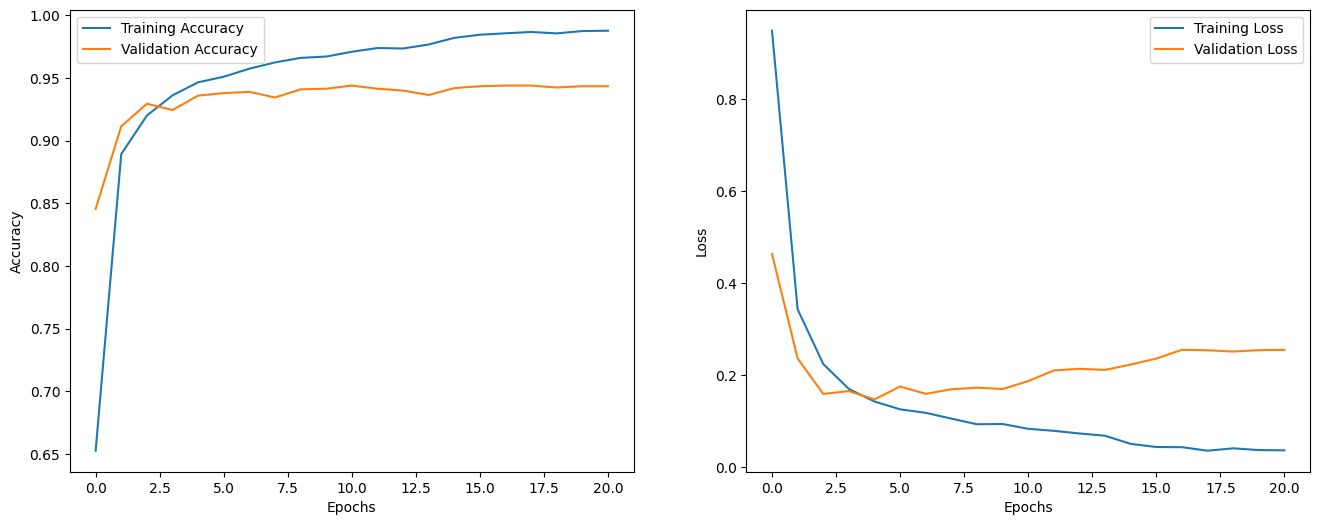

In [59]:
#visualizing the training history
import history_plot

history_plot.show_history(h_opt)

In [64]:
#test set
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)


In [65]:
from tensorflow.keras.models import load_model

# Load the best saved model from the file
best_model = load_model('best_model')

In [66]:
_ = best_model.evaluate(test_seq, np.array(test_labels))

63/63 [==============================] - 1s 3ms/step - loss: 0.2064 - accuracy: 0.9330


In [68]:
#random example from test set
example = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[example])
print('Emotion:', index_to_class[test_labels[example]])

p = best_model.predict(np.expand_dims(test_seq[example], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: im feeling completely idiotic by not being ablo to contribute
Emotion: sadness
1/1 [==============================] - 1s 1s/step
Predicted Emotion: sadness


In [69]:
#take a look at all the predictions against the ground truth
preds = best_model.predict(test_seq)

63/63 [==============================] - 0s 3ms/step


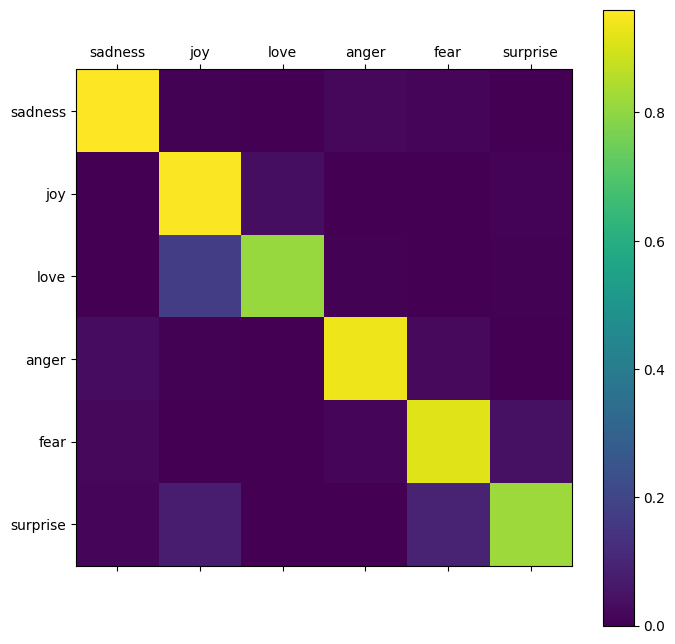

In [70]:
#visualizing the training history
import confusion_matrix

confusion_matrix.show_confusion_matrix(
    np.array(test_labels), 
    np.argmax(preds, axis=1), 
    [index_to_class[i] for i in range(len(index_to_class))]
)